# Classification of Periglacial features from DEM

### Place this file in a root directory, with a subfolder named DEM containing:
    Subfolder "Filtered"
    Subfolder "Lake Data"
    Subfolder "ver_x-y"
    Initial DEM .tf file
    
### This Script attempts to identify Rogen Moraine features using minibatch k-means.
1. Filter out DEM with a high pass filter (<300m)
2. Filter out DEM with a low pass filter (>40m)
3. Derive morphometrics: Slope, Curvature, Topographic Wetness Index, General Slope
4. Filter out regions where Rogen Moraines cannot form
5. Enact K-Means clustering

### Possible Improvements:
    Additional morphometric parameters
    Regional exclusion of terrain unsuitable for Rogen Moraine
    Erode & Dilute to make clusters more reasonable
    Classify features by geometry
    
Current Iteration defined for linux

### Environment Setup
1. Install Mamba: 
    conda install mamba -n base conda-forge
2. Setup Environment:
    mamba create -c conda-forge -n detect_moraine ipython numpy pandas matplotlib ipykernel scikit-learn gdal rasterio pyproj opencv scikit-image richdem jupyter
3. Activate Environment:
    conda init
    conda activate detect_moraine
    
### Pre-run:
Produce TWI raster using SAGA in command line.

# Import Libraries

In [1]:
import cv2
import csv
import rasterio
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
import richdem as rd
import sys
from sklearn.datasets import load_iris
from skimage.measure import label, regionprops, regionprops_table
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import pandas as pd
from matplotlib.colors import LightSource
import time
import pkg_resources
import os

# Import Raster DEM data

In [2]:
rast = rasterio.open('DEM/Karasjok_Validation/dtm10_33_167_188.tif')
arr = rast.read(1)

# Generate Morphometrics

### Define Kernel for filtering DEM

In [3]:
def kernel_square(nPix):
    print("Averaging kernel of "+ str(nPix) + " by " + str(nPix))
    kernel = np.empty([nPix, nPix])
    kernel.fill(1)
    kernel /= kernel.sum()
    return kernel
def smooth(mat, kernel):
    r = cv2.filter2D(mat, -1, kernel)
    print("Smoothing complete ...")
    return r

### Generate & Export 400m filtered DEM and produce general slope layer

In [4]:
med_400 = smooth(arr, kernel_square(34)) #orig 40
rast.transform
filteredDEM = rasterio.open('DEM/Karasjok_Validation/med400_33_167_188.tif', 'w', driver='GTiff',
                            height = arr.shape[0], width = arr.shape[1],
                            count=1, dtype=str(arr.dtype), crs={'init': 'EPSG:3045'},
                            transform = rast.transform)
filteredDEM.write(med_400, 1)
filteredDEM.close()

Averaging kernel of 34 by 34
Smoothing complete ...


In [5]:
r400 = rd.rdarray(med_400, no_data=np.nan)
genslope = rd.TerrainAttribute(r400, attrib='slope_riserun')

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.044942


### Generate 30-400 median filter

In [6]:
med_300 = smooth(arr, kernel_square(40)) # orig 40
hpass300 = arr-med_300
med_40 = smooth(hpass300, kernel_square(4)) # orig 3

# Export Low Pass Filter (400)
LPass = med_300
rast.transform
filteredDEM = rasterio.open('DEM/Karasjok_Validation/Filters/LP400_33_167_188.tif', 'w', driver='GTiff',
                            height = arr.shape[0], width = arr.shape[1],
                            count=1, dtype=str(arr.dtype), crs={'init': 'EPSG:3045'},
                            transform = rast.transform)
filteredDEM.write(med_300, 1)
filteredDEM.close()

# Export High Pass Filter (30)
HPI = smooth(arr, kernel_square(4))
HPass = arr - HPI
rast.transform
filteredDEM = rasterio.open('DEM/Karasjok_Validation/Filters/HP30_33_167_188.tif', 'w', driver='GTiff',
                            height = arr.shape[0], width = arr.shape[1],
                            count=1, dtype=str(arr.dtype), crs={'init': 'EPSG:3045'},
                            transform = rast.transform)
filteredDEM.write(HPass, 1)
filteredDEM.close()

# Export Median Filter (30 - 400)
MED = med_40
rast.transform
filteredDEM = rasterio.open('DEM/Karasjok_Validation/Filters/MED30-400_33_167_188.tif', 'w', driver='GTiff',
                            height = arr.shape[0], width = arr.shape[1],
                            count=1, dtype=str(arr.dtype), crs={'init': 'EPSG:3045'},
                            transform = rast.transform)
filteredDEM.write(med_40, 1)
filteredDEM.close()

Averaging kernel of 40 by 40
Smoothing complete ...
Averaging kernel of 4 by 4
Smoothing complete ...
Averaging kernel of 4 by 4
Smoothing complete ...


### Richdem Morphometrics

In [7]:
rmed40 = rd.rdarray(MED, no_data=np.nan)
slope = rd.TerrainAttribute(rmed40, attrib='slope_riserun')
curv = rd.TerrainAttribute(rmed40, attrib='curvature')

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0451655

A Curvature attribute calculation
C Zevenbergen, L.W., Thorne, C.R., 1987. Quantitative analysis of land surface topography. Earth surface processes and landforms 12, 47–56.



t Wall-time = 0.024642


### Import SAGA Morphometrics

In [8]:
wetind = rasterio.open('DEM/Karasjok_Validation/TWI10_33_167_188.tif')
wIndex = wetind.read(1)

### Standardise from Float to 16bit Signed Integer

In [9]:
slope = slope.astype(np.int16)
curv = curv.astype(np.int16)
wIndex = wIndex.astype(np.int16)

### Define clustering dataframe using Pandas

In [10]:
df = pd.DataFrame()

df['elev40_300'] = MED.flatten()
df['genslope'] = genslope.flatten()
df['slope'] = slope.flatten()
df['curv'] = curv.flatten()
df['wIndex'] = wIndex.flatten()

In [11]:
df['pix_id'] = df.index

# Masking Morphometric Features

## Laplacian Curvature of Guassian Operator

### Generate Kernel

In [12]:
def lapogaus(x, y, sigma):
    op = -1/(np.pi * sigma **4)*(1-((x**2 + y**2)/(2*sigma**2)))*np.exp(-((x**2 + y**2)/(2*sigma**2)))
    return op
def laplacian_of_gaussian(n, sigma):
    x = np.arange(-n,n)
    y = np.arange(-n,n)
    Xs, Ys = np.meshgrid(x,y)
    kernel = lapogaus(Xs,Ys,sigma)
    return kernel
def convolve_array(arr, kernel):
    res = cv2.filter2D(arr, -1, kernel)
    return res
kernel = laplacian_of_gaussian(71, 15)

### Generate Laplacian Curvature raster using kernel & define thresholding value

In [13]:
lapcurv = cv2.filter2D(arr, -1, kernel)
lcval = 0.051

biglopass = smooth(arr, kernel_square(100)) # 1-2km filter
lplap = cv2.filter2D(biglopass, -1, kernel)
lplapval = 0.012

Averaging kernel of 100 by 100
Smoothing complete ...


### Import lake mask

In [14]:
lakemaskrast = rasterio.open('DEM/Karasjok_Validation/Lakes10_33_167_188.tif')
lakearr = lakemaskrast.read(1)

### Import løsmasse

In [15]:
lmass = rasterio.open('DEM/Karasjok_Validation/løsmasse10_33_167_188.tif')
lmassarr = lmass.read(1)

### Define full mask and add to df

In [16]:
maskarea = lapcurv<-lcval
maskarea = lplap<-lplapval
maskarea[genslope>0.692]=True
maskarea[lakearr==1]=True
maskarea[lmassarr==1]=True

In [17]:
df['mask'] = maskarea.flatten()
df['pix_id'] = df.index
df_sub = df.loc[df['mask']==False]
print(df_sub)

         elev40_300  genslope  slope  curv  wIndex   pix_id   mask
0          2.497921  0.000000      0     0       6        0  False
1          2.497921  0.023945      0    18       7        1  False
2          2.312829  0.063019      0     7       6        2  False
3          2.056850  0.093803      0     1       6        3  False
4          1.781639  0.122139      0    -3       6        4  False
...             ...       ...    ...   ...     ...      ...    ...
2252996   -9.789968  0.098161      0   -36       8  2252996  False
2252997  -10.200159  0.071619      0   -23       8  2252997  False
2252998  -10.740097  0.048986      0   -24       8  2252998  False
2252999  -11.360620  0.035354      0   -55       8  2252999  False
2253000  -11.735323  0.021327      0   -67       8  2253000  False

[1312464 rows x 7 columns]


Text(0.5, 1.0, 'Mask')

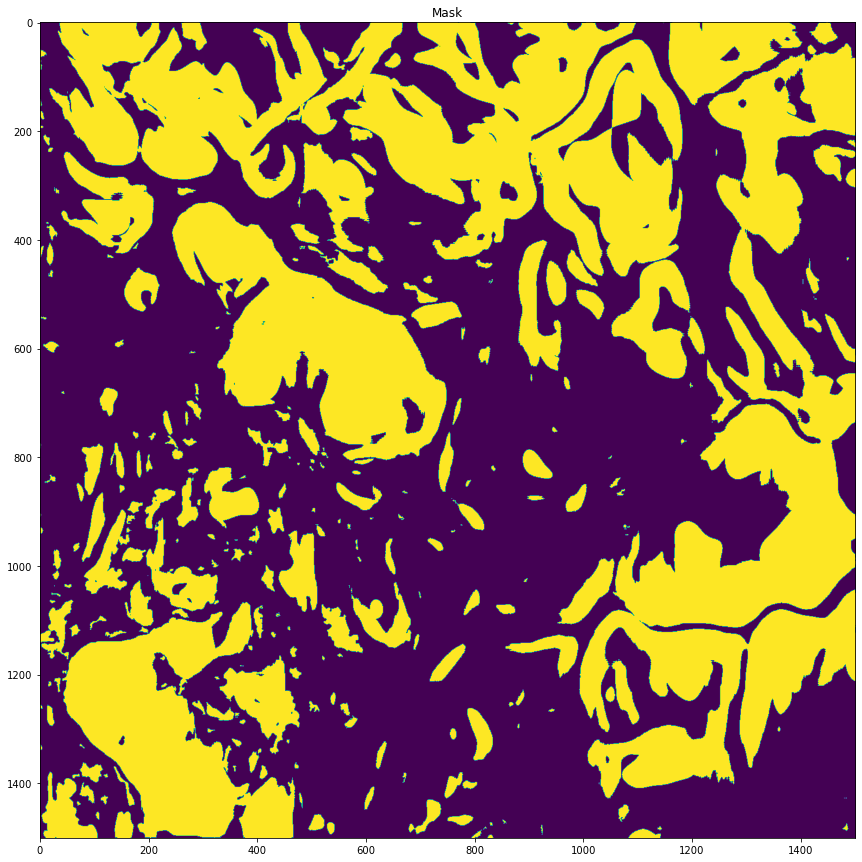

In [18]:
# Display Mask
plt.figure(figsize=(15,15))
ls = LightSource(azdeg=225, altdeg=45)
shade = ls.hillshade(arr, vert_exag=1, dx=10, dy=10, fraction=1.0)
plt.imshow(shade, cmap=plt.cm.gray)
plt.imshow(np.reshape(maskarea, med_40.shape))
plt.title('Mask')

# Minibatch K-Means clustering

### Setup

In [19]:
def scale_df(df_param, scaler=StandardScaler()):
    print('---> Scaling data prior to clustering')
    df_scaled = pd.DataFrame(scaler.fit_transform(df_param.values),
                             columns=df_param.columns, index=df_param.index)
    return df_scaled, scaler
def minibatch_kmeans_clustering(df_param, n_clusters=100, n_cores=4, seed=None, **kwargs):
    X = df_param.to_numpy()
    col_names = df_param.columns
    print('---> Clustering with Mini-Batch K-Means in {} clusters'.format(n_clusters))
    start_time = time.time()
    miniBKmeans = cluster.MiniBatchKMeans(n_clusters=n_clusters, batch_size=2048, random_state=seed, **kwargs).fit(X)
    print('---> Mini-Batch Kmean finished in {}s'.format(np.round(time.time()-start_time), 0))
    df_centers = pd.DataFrame(miniBKmeans.cluster_centers_, columns=col_names)
    df_param['cluster_labels'] = miniBKmeans.labels_
    return df_centers, miniBKmeans, df_param['cluster_labels']

### Determining optimal cluster count

REMEMBER TO DISABLE ONCE FOUND - LONG PROCESSING DURATION

In [20]:
df_scaled, scaler = scale_df(df_sub)

#distortions = []
#inertias = []
#
#Xa = pd.DataFrame(df_scaled)
#data = Xa[['slope', 'curv', 'wIndex', 'mask']]
#
#sse = {}
#for k in range(1, 11):
#    kmeans = KMeans(n_clusters=k, max_iter=300).fit(data)
#    data['clusters'] = kmeans.labels_
#    sse[k] = kmeans.inertia_

---> Scaling data prior to clustering


In [21]:
# plot elbow
#plt.figure()
#plt.plot(list(sse.keys()), list(sse.values()))
#plt.xlabel("Cluster count")
#plt.ylabel("SSE")
#plt.show()

In [22]:
print(df_scaled)

         elev40_300  genslope     slope      curv    wIndex    pix_id  mask
0          0.883882 -2.239113 -0.293419  0.001370 -0.628579 -1.998912   0.0
1          0.883882 -2.097455 -0.293419  0.622000  0.251631 -1.998910   0.0
2          0.825557 -1.866300 -0.293419  0.242726 -0.628579 -1.998909   0.0
3          0.744894 -1.684185 -0.293419  0.035850 -0.628579 -1.998907   0.0
4          0.658170 -1.516553 -0.293419 -0.102068 -0.628579 -1.998905   0.0
...             ...       ...       ...       ...       ...       ...   ...
2252996   -2.988231 -1.658399 -0.293419 -1.239889  1.131841  1.674123   0.0
2252997   -3.117489 -1.815423 -0.293419 -0.791656  1.131841  1.674124   0.0
2252998   -3.287632 -1.949318 -0.293419 -0.826136  1.131841  1.674126   0.0
2252999   -3.483169 -2.029963 -0.293419 -1.894998  1.131841  1.674128   0.0
2253000   -3.601244 -2.112947 -0.293419 -2.308750  1.131841  1.674129   0.0

[1312464 rows x 7 columns]


### Enact Clustering

In [23]:
df_centers, miniBkmeans, df_sub['cluster_labels'] = minibatch_kmeans_clustering(df_scaled, n_clusters=4, n_cores=4, seed=123)
df['cluster_sub'] = np.nan
df.cluster_sub.loc[df_sub.pix_id] = df_sub.cluster_labels

---> Clustering with Mini-Batch K-Means in 4 clusters
---> Mini-Batch Kmean finished in 7.0s


/tmp/ipykernel_12335/596129056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_centers, miniBkmeans, df_sub['cluster_labels'] = minibatch_kmeans_clustering(df_scaled, n_clusters=4, n_cores=4, seed=123)
/tmp/ipykernel_12335/596129056.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.cluster_sub.loc[df_sub.pix_id] = df_sub.cluster_labels


### Display Output

Text(0.5, 1.0, 'Subtracted_Clustered_Map')

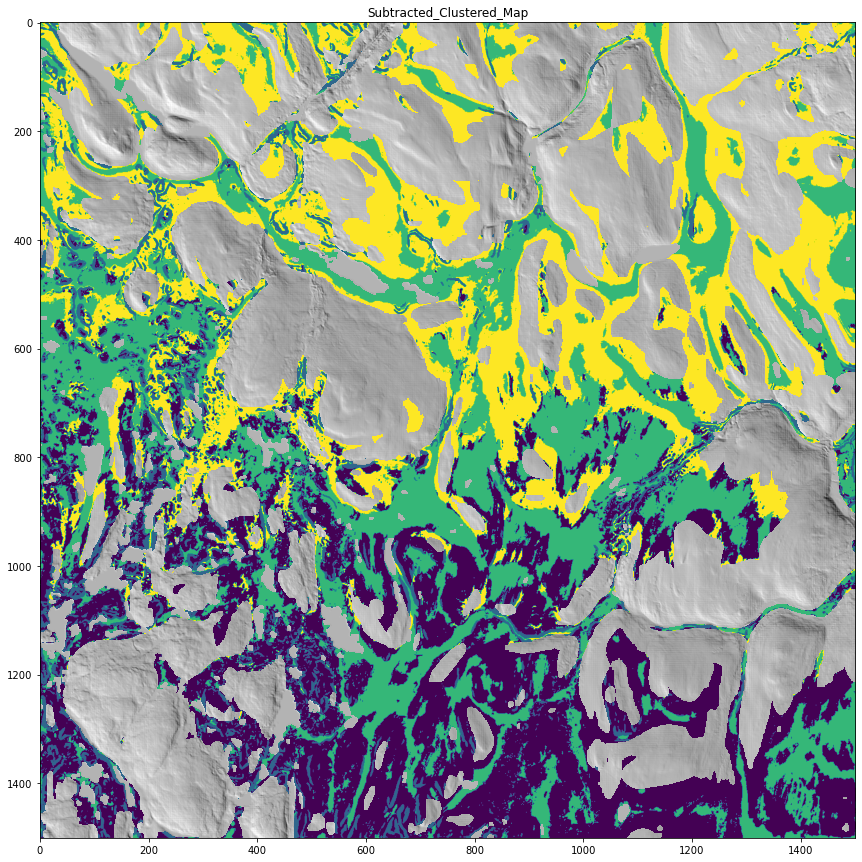

In [24]:
plt.figure(figsize=(15,15))
ls = LightSource(azdeg=225, altdeg=45)
shade = ls.hillshade(arr, vert_exag=1, dx=10, dy=10, fraction=1.0)
plt.imshow(shade, cmap=plt.cm.gray)
plt.imshow(np.reshape(df.cluster_sub.values, med_40.shape))
plt.title('Subtracted_Clustered_Map')

### Export Output

In [25]:
sel = np.reshape(df.cluster_sub.values, med_40.shape)
with rasterio.open(
    'DEM/MBKM_Improvement/Outputs/Systematic_Karasjok/MBKM_33_167_188_poster100_4c.tif',
    'w',
    driver='GTiff',
    height=sel.shape[0],
    width=sel.shape[1],
    count=1,
    dtype=sel.dtype,
    crs={'init': 'EPSG:3045'},
    transform=rast.transform,
) as dst:
    dst.write(np.reshape(df.cluster_sub.values, med_40.shape), 1)